# Image analysis of FP plates to identify proportion of high expressors + (some day) identify clone position with highest FP expression

### Required Modules

In [13]:
%matplotlib inline
from PIL import Image
import numpy as np
import cv2 # opencv_python
import matplotlib.pyplot as plt
import statistics

### Image file souce

In [14]:
analysis_folder = "Example" # Folder the images are in to be analysed

#A list of the images to be analysed, in order 
chl_images = ["Exp1-Chl.tif","Exp2-Chl.tif","Exp3-Chl.tif"]
#                 ↓ The chlorophyll channel corresponds to the FP signal below
fp_images = ["Exp1-YFP.tif","Exp2-YFP.tif","Exp3-YFP.tif"]

#Some custom thresholds for channel fluorescence, ordered as per the images above
# This sometimes takes some fine-tuning to ensure proper masking - for example, the top corners of the plate 
#TODO (one day) detect and then adjust automatically 
chl_base_threshhold = [25,40,40,40,40,40] 
fp_base_threshhold = [0,0,0,0,0,0] # Currently not used


### Some custom functions

In [15]:
def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    ''' Resize a cv2.img for better display 
    source: https://stackoverflow.com/questions/35180764/opencv-python-image-too-big-to-display    
    '''    
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    return cv2.resize(image, dim, interpolation=inter)
    

### Now for the magic

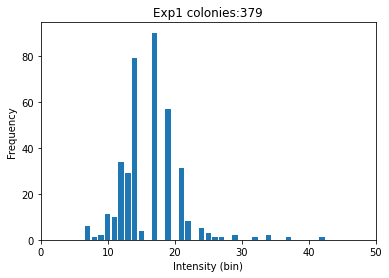

Exp1 colonies:379
Most frequent bin/fluorescence:(16,17) - mode:16.5
Max bin/fluorescence:(41,42) - max:41.5
Colonies above threshhold(25): 9.0


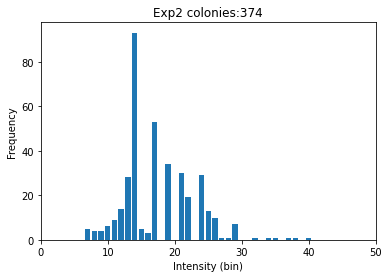

Exp2 colonies:374
Most frequent bin/fluorescence:(13,14) - mode:13.5
Max bin/fluorescence:(39,40) - max:39.5
Colonies above threshhold(25): 25.0


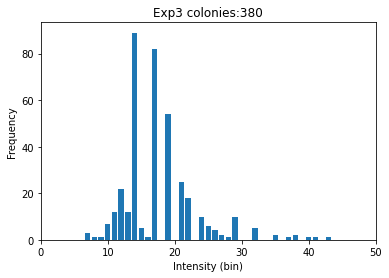

Exp3 colonies:380
Most frequent bin/fluorescence:(13,14) - mode:13.5
Max bin/fluorescence:(51,52) - max:51.5
Colonies above threshhold(25): 32.0
Summary 
 -------- 
Exp1 colonies:379
Most frequent bin/fluorescence:(16,17) - mode:16.5
Max bin/fluorescence:(41,42) - max:41.5
Colonies above threshhold(25): 9.0
Exp2 colonies:374
Most frequent bin/fluorescence:(13,14) - mode:13.5
Max bin/fluorescence:(39,40) - max:39.5
Colonies above threshhold(25): 25.0
Exp3 colonies:380
Most frequent bin/fluorescence:(13,14) - mode:13.5
Max bin/fluorescence:(51,52) - max:51.5
Colonies above threshhold(25): 32.0



In [16]:

show_mask = False # Set to false to speed up processing when happy with mask

# Analysis mode - currently only MODE implimented 
MODE = 0
MEAN = 1
intensity_analysis = MODE

output_holder = "Summary \n -------- \n"

for idx in range(0,len(chl_images)):
    
    #Load chlorophyll image 
    chl = cv2.imread(analysis_folder+"/"+chl_images[idx], cv2.IMREAD_GRAYSCALE) 
    
    # Create a mask using the chlorophyll image and binary thresholding - you may need to adjust threshold
    _, mask = cv2.threshold(chl, chl_base_threshhold[idx], 255,cv2.THRESH_BINARY)# cv2.THRESH_OTSU)
    
    # Do some morphological opening to get rid of small artifacts
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))) # If you see spots - you can increase the morph_ellipse size (15,15) → (20,20)
    
    # compute the connected component    
    output = cv2.connectedComponentsWithStats(mask, cv2.CV_32S)
    (numLabels, markers, stats, centroids) = output

    #Load FP image 
    fp = cv2.imread(analysis_folder+"/"+fp_images[idx], cv2.IMREAD_GRAYSCALE)
    
    # This is for sorting the colonies so they are more better ordered 
    for i in range(1, numLabels):        
        #TODO, currently not done
        break 
        #print(stats[i])
        #[ 795  546   37   39 1134]
        # extract the connected component statistics and centroid for the current label
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]
        #Do some sort of sorting
    
    # Show mask image - if requested
    if show_mask:    
        #Adjust here to fix the title
        title = chl_images[idx][:-8]+" colonies:"+str(numLabels)
        plt.imshow(mask)
        plt.title('Mask: '+title)
        plt.show()
        resize_mask = ResizeWithAspectRatio(mask, width=1280) # Resize by width OR
        cv2.imshow("Mask: "+title, resize_mask)   
        #reveal of colonies 
        if True: 
            for i in range(1, numLabels):     
                componentMask = (markers > i).astype("uint8") * 255 
                resize_image = ResizeWithAspectRatio(componentMask, width=1280) # Resize by width 
                cv2.imshow("Mask: "+title, resize_image)
                cv2.waitKey(1)    	        
        cv2.destroyAllWindows()   

    #Create a np array as a tally for the fluorescence values
    tally = np.zeros(255)
    
    # labels[0] is the background
    for label in range(1,numLabels):
        # compute the histogram over the entire 256 levels of intensity
        hist, bins = np.histogram(fp[markers==label], bins=range(256))
        # do whatever you like to hist
        if intensity_analysis == MODE:
            tally[hist.argmax()] += 1
        else: 
            #TODO Per
            pass 
    
    plt.bar(bins[1:], tally)
    title = chl_images[idx][:-8]+" colonies:"+str(label)
    plt.title(title)
    plt.xlabel("Intensity (bin)")
    plt.ylabel("Frequency")
    plt.xlim(xmin = 0, xmax = 50)
    plt.show()    

    #Output statistics
    mode_index = tally.argmax()
    
    output_holder += title +"\n"
    print(title)
    mode_output = 'Most frequent bin/fluorescence:(' + str(bins[mode_index]) + ',' + str(bins[mode_index+1]) + ') - mode:'+ str((bins[mode_index] + bins[mode_index+1])/2)
    output_holder += mode_output +"\n"
    print(mode_output)
    max_index = np.where(tally)[0].max()
    max_output = 'Max bin/fluorescence:(' + str(bins[max_index]) + ',' + str(bins[max_index+1]) + ') - max:'+ str((bins[max_index] + bins[max_index+1])/2)
    output_holder += max_output +"\n"
    print(max_output)
    threshhold = 25
    count = 0
    for a in range(threshhold, len(bins)-1):
        count += tally[a]    
    threshhold_output = "Colonies above threshhold("+str(threshhold)+"): "+str(count)
    output_holder += threshhold_output +"\n"
    print(threshhold_output)    

print(output_holder)

cv2.destroyAllWindows()

In [17]:
print(output_holder)

Summary 
 -------- 
Exp1 colonies:379
Most frequent bin/fluorescence:(16,17) - mode:16.5
Max bin/fluorescence:(41,42) - max:41.5
Colonies above threshhold(25): 9.0
Exp2 colonies:374
Most frequent bin/fluorescence:(13,14) - mode:13.5
Max bin/fluorescence:(39,40) - max:39.5
Colonies above threshhold(25): 25.0
Exp3 colonies:380
Most frequent bin/fluorescence:(13,14) - mode:13.5
Max bin/fluorescence:(51,52) - max:51.5
Colonies above threshhold(25): 32.0



### Sources
Various discussions used to create

https://stackoverflow.com/questions/56412418/how-do-i-make-a-mask-from-one-image-and-then-transfer-it-to-another

https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html

https://stackoverflow.com/questions/35180764/opencv-python-image-too-big-to-display
